### 시계열 분석 정상성 확인 요약

- 평균일정 x -> 차분
- 분산 일정 x -> 차분 이전에 로그 변환 수행 np.log로 변환 가능

1. 시계열 데이터 불러와서 데이터 가공
2. 정규성, 이분산성 시각화 필요한지 확인 후 필요하면 수행
3. ACF, PACF 시각화 adf test로 비정상 시계열 확인
4. 차분 등 수행 후, 3번 과정과 비교하여 정상 시계열 변환 완료 확인

In [1]:
import pandas as pd
data=pd.read_csv("market-price.csv")
data.head()

,Timestamp,market-price
0,2021-08-30 00:00:00,48806.78
1,2021-08-31 00:00:00,47074.77
2,2021-09-01 00:00:00,47155.87
3,2021-09-02 00:00:00,48862.76
4,2021-09-03 00:00:00,49329.01


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt

series=pd.read_csv("market-price.csv", header=0, names=['day', 'price'])

#str->datetime
series['day']=pd.to_datetime(series['day'])
#index로 설정
series.index=series['day']
series.set_index('day', inplace=True)

series.head()

,price
day,
2021-08-30,48806.78
2021-08-31,47074.77
2021-09-01,47155.87
2021-09-02,48862.76
2021-09-03,49329.01


- 정상 시계열인지 아닌지 확인하기 위해 시각화 진행 (정규성, 이분산성 시각화)

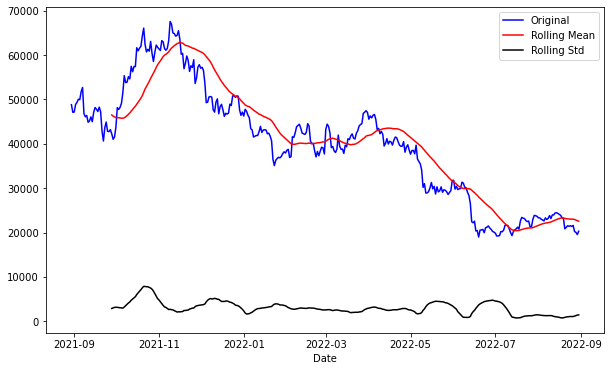

In [3]:
def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()
    
plot_rolling(series, 30)

평균과 분산이 일정한지 확인해본 결과, 평균은 일단 꾸준히 하락하고 있는 것을 확인

- 추세요인, 계절요인, 불규칙 요인(seasonal_decompose로 plot)

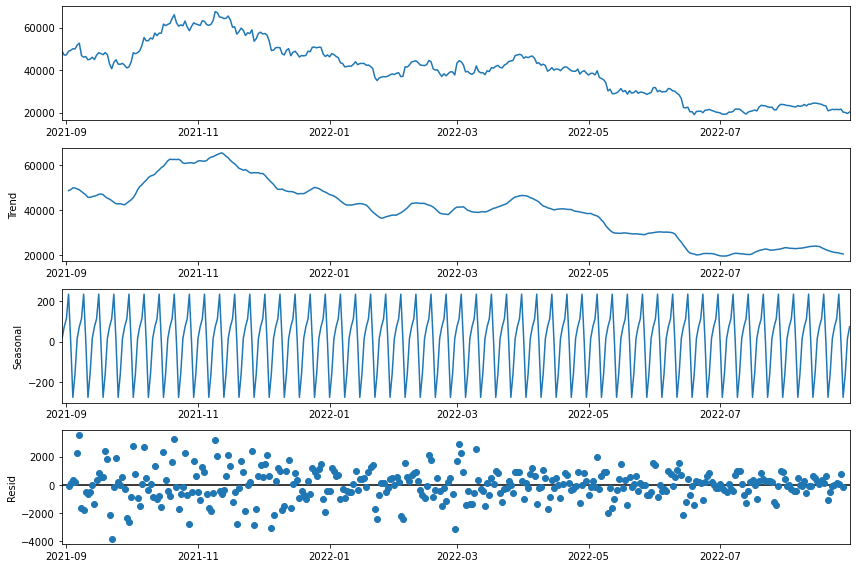

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

result=sm.tsa.seasonal_decompose(series, model='additive')
plt.rcParams['figure.figsize']=[12,8]
result.plot()
plt.show()

<AxesSubplot:xlabel='day'>

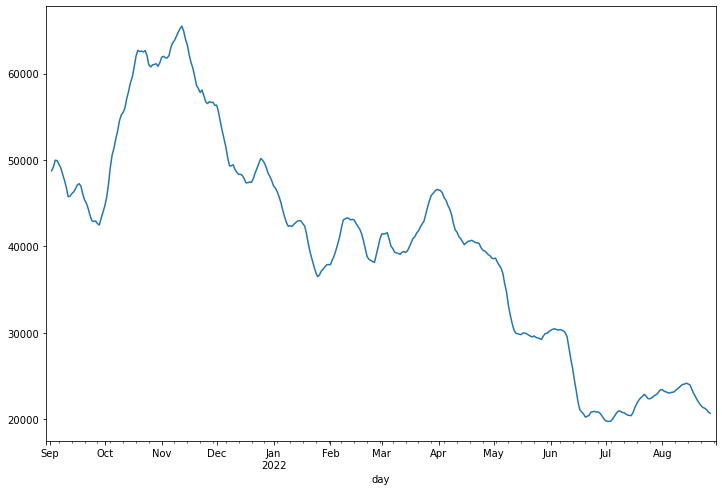

In [5]:
result.trend.plot()

이렇게 result.obsered, result.trned, result.seasonal, result.resid로 각 그래프의 실제 값을 볼 수 있다.

result.observed-result.seasonal로 계절요인 제거 가능

### 시계열 정상성 여부 분석 (kpss test / ADF test)

- kpss test(혹시 모르니)

H0 : 해당 시계열은 정상 시계열이다. H1 : 비정상 시계열이다.

In [12]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""} stationary')
    
kpss_test(series)

KPSS Statistic: 1.7508916324536314
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not  stationary


KPSS 결과 : pvalue가 0.05보다 작아 귀무가설을 기각한다. 즉 비정상 시계열이다.

- 비정상 시계열 확인(ACF 그래프)

비정상시계열 : ACF가 느리게 감소, 정상시계열 : ACF가 빠르게 0으로 감소

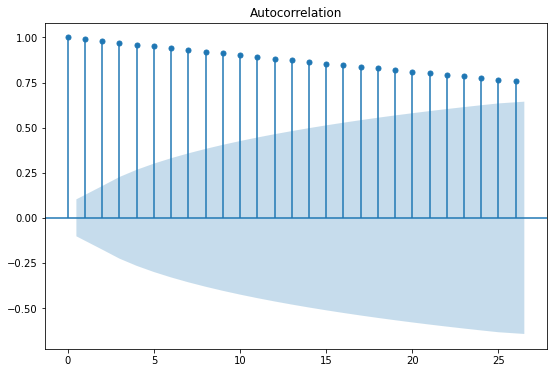

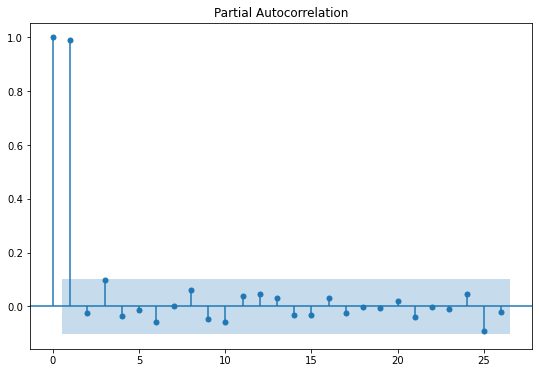

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize']=[9,6]
plot_acf(series)
plot_pacf(series)
plt.show()

ACF가 천천히 감소하므로 비정상 시계열이라고 판단.

-> 차분을 통해 정상 시계열로 변환

KPSS Statistic: 0.10758206974907136
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is  stationary
None
-------------


<AxesSubplot:xlabel='day'>

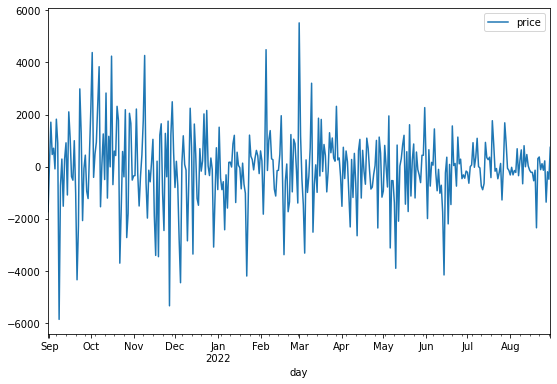

In [13]:
diff_1=series.diff(periods=1).iloc[1:] #차분1

print(kpss_test(diff_1))
print("-------------")
diff_1.plot()

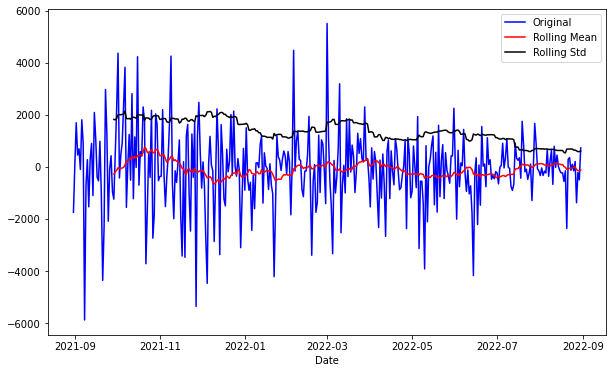

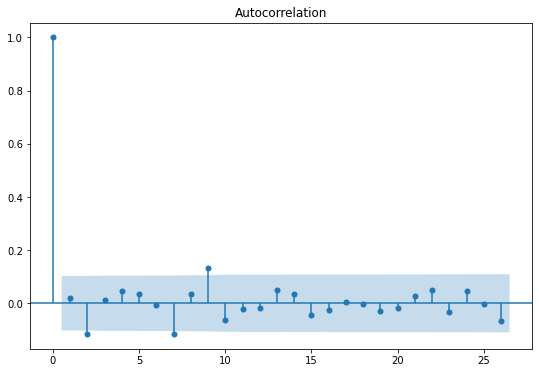

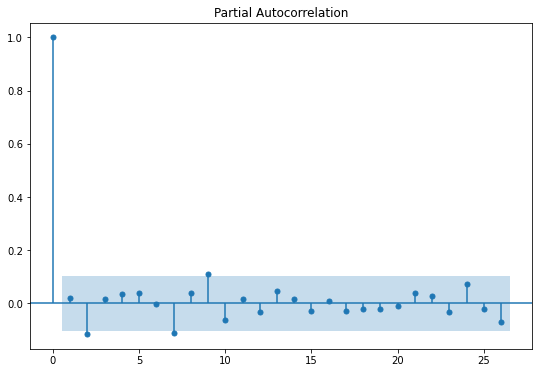

In [9]:
plot_rolling(diff_1, 30)

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

1차 차분 후, ACF 값이 확 감소하였고, 평균과 분산도 거의 일정함.

- ADF test

H0 : 해당 시계열은 비정상 시계열이다. H1 : 정상 시계열이다.

In [10]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(series)
print(result[0]) #ADF
print(result[1]) #p-value

-0.641132001173393
0.8614144431327684


p-value가 0.05보다 커 귀무가설을 기각할 수 없다. 해당 시계열은 비정상 시계열

In [11]:
result=adfuller(diff_1)
print(result[0]) #차분 후 ADF
print(result[1]) #차분 후 p-value

-14.91051755076732
1.4608485303225722e-27


p-value가 0.05보다 작아 귀무가설을 기각한다. 해당 시계열을 정상시계열이다.